In [1]:
import os
import gmaps
import gmaps.datasets
import pandas as pd
import seaborn as sns
import numpy as np
from time import sleep

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
%pylab inline

# See the https://jupyter-gmaps.readthedocs.io/en/latest/install.html for installation
# set GOOGLE_API_KEY in your environment
gmaps.configure(api_key=os.environ["GOOGLE_API_KEY"])

Populating the interactive namespace from numpy and matplotlib


### Loading Data

In [4]:
date_cols = ['pickup_datetime', 'dropoff_datetime',]
ride_data = pd.read_csv('ride_data.csv', parse_dates=date_cols)

In [5]:
pickup_locations = ride_data[['pickup_latitude', 'pickup_longitude']]
locations = pickup_locations.sample(frac=0.1).values

In [6]:
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations))
fig

Figure(layout=FigureLayout(height='420px'))

In [7]:
ride_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

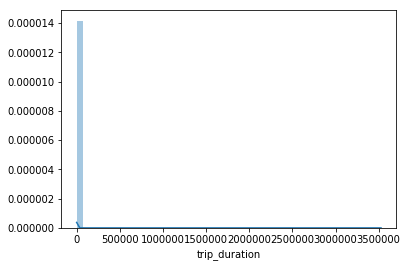

In [8]:
sns.distplot(ride_data['trip_duration'])

In [9]:
pickup_params = ['pickup_longitude', 'pickup_latitude']
dropoff_params = ['dropoff_longitude', 'dropoff_latitude']

carpool_columns = ['trip_duration', 'pickup_datetime', 'passenger_count'] + pickup_params + dropoff_params

carpool_data = ride_data[carpool_columns].sample(frac=0.2, random_state=501)


duration_cut = np.quantile(carpool_data['trip_duration'], q=0.8, axis=0)

carpool_data = carpool_data[(carpool_data['trip_duration'] >= duration_cut) & (carpool_data['passenger_count'] == 1)]

In [10]:
def round_datetime(tm, round_minutes = 30):
    discard = datetime.timedelta(minutes=tm.minute % round_minutes,
                             seconds=tm.second,
                             microseconds=tm.microsecond)
    tm -= discard
    if discard >= datetime.timedelta(minutes=round_minutes/2):
        tm += datetime.timedelta(minutes=round_minutes)
    return tm

In [11]:
def datetime_to_numeric(tm):
    return(tm.hour * 60 + tm.minute)

def datetime_to_time(tm):
    return('{}:{}'.format(tm.hour, tm.minute))

In [12]:
carpool_data['pickup_time_slot'] = carpool_data.pickup_datetime.apply(lambda x: datetime_to_time(round_datetime(x)))

In [13]:
carpool_data.head()

,trip_duration,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_time_slot
1000460,1523,2016-06-03 19:39:14,1,-73.972466,40.756702,-73.984596,40.692001,19:30
17142,1441,2016-05-05 09:21:24,1,-73.968826,40.764603,-73.984962,40.750675,9:30
252614,1274,2016-05-24 08:51:36,1,-73.982338,40.768417,-73.981750,40.755737,9:0
234168,1263,2016-02-24 13:30:51,1,-74.003250,40.739037,-73.983727,40.762859,13:30
1440940,1232,2016-05-27 23:55:19,1,-73.987312,40.756779,-73.882553,40.737171,0:0


In [14]:
from collections import Counter
Counter(carpool_data.pickup_time_slot).most_common(10)

[('18:0', 1345),
 ('18:30', 1327),
 ('14:30', 1299),
 ('15:0', 1241),
 ('15:30', 1206),
 ('17:30', 1198),
 ('19:0', 1152),
 ('12:30', 1149),
 ('13:30', 1144),
 ('14:0', 1136)]

In [15]:
from sklearn.cluster import DBSCAN

In [16]:
# 1 unit distance in lat long corresponds to 111km in metric units
# We keep 300 m as the maximum walking distance

max_pickup_distance = 0.1 * 1/ 111
max_dropoff_distance = 5 * max_pickup_distance


pickup_dbscan = DBSCAN(
    eps = max_pickup_distance,
    min_samples = 2,
    metric = 'l1'
)
dropoff_dbscan = DBSCAN(
    eps = max_dropoff_distance,
    min_samples = 2,
    metric = 'l1'
)

In [17]:
considered_time_slots = ['3:0', '9:0', '12:0', '15:0', '19:0',]
considered_time_colors = ['black', 'blue', 'green', 'yellow' , 'red']

In [18]:
timewise_cluster_data = []


for time_slot in considered_time_slots:

    subset_slot_data = carpool_data[(carpool_data.pickup_time_slot == time_slot)]
    X_pickup = subset_slot_data[pickup_params]
    dropoff_data = subset_slot_data[dropoff_params]

    subset_slot_data['pickup_cluster'] = pickup_dbscan.fit_predict(X_pickup)

    subset_slot_data['subset_cluster'] = -2

    for i in set(subset_slot_data.pickup_cluster):
        indices = subset_slot_data.pickup_cluster == i
        X_dropoff = dropoff_data[indices]
        subset_slot_data.loc[indices, 'subset_cluster'] = dropoff_dbscan.fit_predict(X_dropoff)
        
    timewise_cluster_data.append(subset_slot_data)

In [19]:
all_cluster_data = pd.concat(timewise_cluster_data)

In [20]:
all_cluster_data = all_cluster_data[~ ((all_cluster_data.pickup_cluster == -1) | (all_cluster_data.subset_cluster == -1))]

In [21]:
n_clusters = 3
aggregated_cluster_data = all_cluster_data.groupby(['pickup_time_slot', 'pickup_cluster', 'subset_cluster']).agg({
    'pickup_latitude':np.mean,
    'pickup_longitude':np.mean,
    'dropoff_latitude':np.mean,
    'dropoff_longitude':np.mean,
    'passenger_count' :sum,
}).reset_index().sort_values('passenger_count', ascending=False).groupby(['pickup_time_slot',]).head(n_clusters)

aggregated_cluster_data.head(10).reset_index()

,index,pickup_time_slot,pickup_cluster,subset_cluster,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count
0,21,12:0,34,1,40.769608,-73.863442,40.755707,-73.973674,14
1,109,9:0,7,0,40.769350,-73.863179,40.755700,-73.973151,11
2,20,12:0,34,0,40.769415,-73.863291,40.762265,-73.981054,8
3,49,15:0,18,3,40.773939,-73.871904,40.750731,-73.977098,7
4,47,15:0,18,1,40.773873,-73.871693,40.756812,-73.985640,7
5,73,19:0,4,2,40.769474,-73.863139,40.764067,-73.979041,5
6,2,12:0,2,2,40.774084,-73.873116,40.762310,-73.979549,5
7,127,9:0,91,0,40.716009,-74.007114,40.757530,-73.967485,5
8,122,9:0,38,0,40.773808,-73.871023,40.756228,-73.973108,4
9,84,19:0,13,0,40.774111,-73.873379,40.759954,-73.987572,4


In [22]:
color_dict = {x:y for x, y in zip(considered_time_slots, considered_time_colors)}
color_dict

{'3:0': 'black',
 '9:0': 'blue',
 '12:0': 'green',
 '15:0': 'yellow',
 '19:0': 'red'}

In [23]:
fig = gmaps.figure()

for i in aggregated_cluster_data.itertuples():
    pickup_point = (i.pickup_latitude, i.pickup_longitude)
    dropoff_point = (i.dropoff_latitude, i.dropoff_longitude)
    fig.add_layer(gmaps.directions_layer(
        pickup_point,
        dropoff_point,
        stroke_color = color_dict[i.pickup_time_slot],
        show_markers=False,
        )
    )
    sleep(2)

fig

Figure(layout=FigureLayout(height='420px'))

In [24]:
color_dict

{'3:0': 'black',
 '9:0': 'blue',
 '12:0': 'green',
 '15:0': 'yellow',
 '19:0': 'red'}